# Imports | Reads | Filter Patients

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from matplotlib import pyplot
from textwrap import TextWrapper
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, cohen_kappa_score, matthews_corrcoef, roc_curve, roc_auc_score, auc, precision_recall_curve, precision_score, recall_score, f1_score

In [2]:
# Read the stroke_diagnosis.csv file
df = pd.read_csv("CSV\imports\o05_30_percent_filled_dataset.csv")

In [3]:
"""
Choose patients by los and Time Zone
"""

# Reorder hospital_expire_flag column
column_order = list(df.columns)
column_order.remove('hospital_expire_flag')  # Remove 'flag' from the original position
column_order.append('hospital_expire_flag')  # Add 'flag' to the end

# Reindex the DataFrame
df = df.reindex(columns=column_order)

# Filter icu stay less than 10 days
df = df[df['los'] < 10]

# Filter Time Zone
#df = df[df['Time_Zone'] == 16]

# Separate Train - Test Sets

In [4]:
"""
Separate automatic training - test set
keeping patients independent between sets
"""

# Set training percentage. The difference goes to test set
training_percentage = 0.7

# It's already sorted. Just for precaution. Sort by 'subject_id' and 'Time_Zone')
df = df.sort_values(by=['subject_id', 'Time_Zone'])

# Calculate the total number of unique subject IDs
unique_subject_ids = df['subject_id'].nunique()

# Calculate the number of unique subject IDs to include in the training set
train_subject_ids_count = int(training_percentage * unique_subject_ids)

# Initialize variables to track the number of subject IDs included in the training set
subject_ids_in_training = 0

# Initialize empty DataFrames for the training and test sets
train_df = pd.DataFrame(columns=df.columns)
test_df = pd.DataFrame(columns=df.columns)

# Iterate through the sorted DataFrame
for subject_id, subject_data in df.groupby('subject_id'):
    if subject_ids_in_training < train_subject_ids_count:
        # Add this subject's data to the training set
        train_df = pd.concat([train_df, subject_data])
        subject_ids_in_training += 1
    else:
        # Add this subject's data to the test set
        test_df = pd.concat([test_df, subject_data])

# Reset the index of the resulting DataFrames
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

C:\Users\dimop\AppData\Local\Temp\ipykernel_1556\2253970844.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_df = pd.concat([train_df, subject_data])
C:\Users\dimop\AppData\Local\Temp\ipykernel_1556\2253970844.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test_df = pd.concat([test_df, subject_data])


In [5]:
"""
Prepaire the training and test set
in encoding level and set labels
"""

# Concatenate train_df and test_df for consistent encoding of categorical variables
combined_df = pd.concat([train_df, test_df], axis=0)

# Encode categorical variables
categorical_cols = ['gender', 'language', 'marital_status', 'race']
combined_df_encoded = pd.get_dummies(combined_df, columns=categorical_cols)

# Convert 'age' column to numeric type
combined_df_encoded['age'] = pd.to_numeric(combined_df_encoded['age'], errors='coerce')

# Convert 'hospital_expire_flag' column to boolean type
combined_df_encoded['hospital_expire_flag'] = combined_df_encoded['hospital_expire_flag'].astype(bool)


# Split the dataframe at the original row index (before concatenation)
combined_df_encoded_train = combined_df_encoded.iloc[:len(train_df)]
combined_df_encoded_test = combined_df_encoded.iloc[len(train_df):]

# Split data into features and target variable again
X_train = combined_df_encoded_train.drop(['row_count', 'subject_id', 'hadm_id', 'Time_Zone', 'hospital_expire_flag'], axis=1)
y_train = combined_df_encoded_train['hospital_expire_flag']
X_test = combined_df_encoded_test.drop(['row_count', 'subject_id', 'hadm_id', 'Time_Zone', 'hospital_expire_flag'], axis=1)
y_test = combined_df_encoded_test['hospital_expire_flag']

# XGBoost HyperParameter Calculation

In [ ]:
"""
XGBoost Calculate HyperParameter
"""

# We can optimize choosing between 'accuracy', 'precision', 'recall', 'f1'
score_metric = 'accuracy'  

# Create a grid search object for XGBoost Classifier
param_grid = {
    'learning_rate': np.arange(0.01, 1.11, 0.20),
    #'max_depth': np.arange(1, 11, 1),
    #'reg_lambda': np.arange(0.0, 10.1, 0.1),
    #'reg_alpha': np.arange(0.0, 10.1, 0.1),
    #'gamma': np.arange(0.0, 1.1, 0.1)
}

grid_search = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic'),
                           param_grid=param_grid,
                           cv=5,  # Number of folds in cross-validation
                           scoring=score_metric,
                           verbose=1,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
model = grid_search.best_estimator_

# Predict on test set using the best model
predictions = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
kappa = cohen_kappa_score(y_test, predictions)
mcc = matthews_corrcoef(y_test, predictions)
print("Metrics Without HyperParameter")
print("\nBest parameters:", best_params)
print("\nAccuracy:", accuracy)
print("\nCohen's Kappa:", kappa)
print("\nMatthews Correlation Coefficient (MCC):", mcc)

# Additional evaluation metrics
print("\n",classification_report(y_test, predictions))

# Default XGBoost and Manual HyperParameter Adjustment

In [6]:
"""
XGBoost without HyperParameter
"""

# Default XGBoost model parameter
#model = xgb.XGBClassifier()

# HyperParameter XGBoost model
model = xgb.XGBClassifier(learning_rate=0.06999999999999999, max_depth=4, reg_lambda=9.5, reg_alpha=8.6)

# Train the model
model.fit(X_train, y_train)

# Predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
kappa = cohen_kappa_score(y_test, predictions)
mcc = matthews_corrcoef(y_test, predictions)
print("Metrics Without HyperParameter")
print("\nAccuracy:", accuracy)
print("\nCohen's Kappa:", kappa)
print("\nMatthews Correlation Coefficient (MCC):", mcc)

# Additional evaluation metrics
print("\n",classification_report(y_test, predictions))

Metrics Without HyperParameter

Accuracy: 0.904651795429815

Cohen's Kappa: 0.6634445295415103

Matthews Correlation Coefficient (MCC): 0.6772220554973795

               precision    recall  f1-score   support

       False       0.91      0.98      0.94     11792
        True       0.86      0.62      0.72      2912

    accuracy                           0.90     14704
   macro avg       0.89      0.80      0.83     14704
weighted avg       0.90      0.90      0.90     14704



# Most Important Features

In [7]:
# Get feature importances with hyperparameters
most_important_df = model.feature_importances_

# Create a DataFrame to store feature importances along with their corresponding names
most_important_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': most_important_df})

# Scale the importance
most_important_df['Importance'] *= 100000

# Sort the DataFrame by feature importance in descending order
most_important_df = most_important_df.sort_values(by='Importance', ascending=False)

# Print the top N most important features
top_n = 20  # set features number
print(f"Top {top_n} most important features:")
print(most_important_df.head(top_n))

Top 20 most important features:
                                 Feature    Importance
221                                  GCS  11454.320699
80                       O2 Flow (L/min)   5481.569469
222                               Braden   2934.834920
13                           Bicarbonate   1668.238081
11                             Anion Gap   1429.596543
60                      PEEP set (cmH2O)   1376.653183
104         Mean Airway Pressure (cmH2O)   1259.127259
10                  Alkaline Phosphatase   1240.550540
25                         Urea Nitrogen   1133.028045
81                  Inspired O2 Fraction   1105.611026
78                            Pain Level   1102.947351
102  Respiratory Rate (Total) (insp/min)   1071.326248
122                           Called Out   1047.362201
56          Arterial CO2 Pressure (mmHg)   1037.857123
217                Glucose (whole blood)    958.672725
43                       Red Blood Cells    953.169446
9                              Al

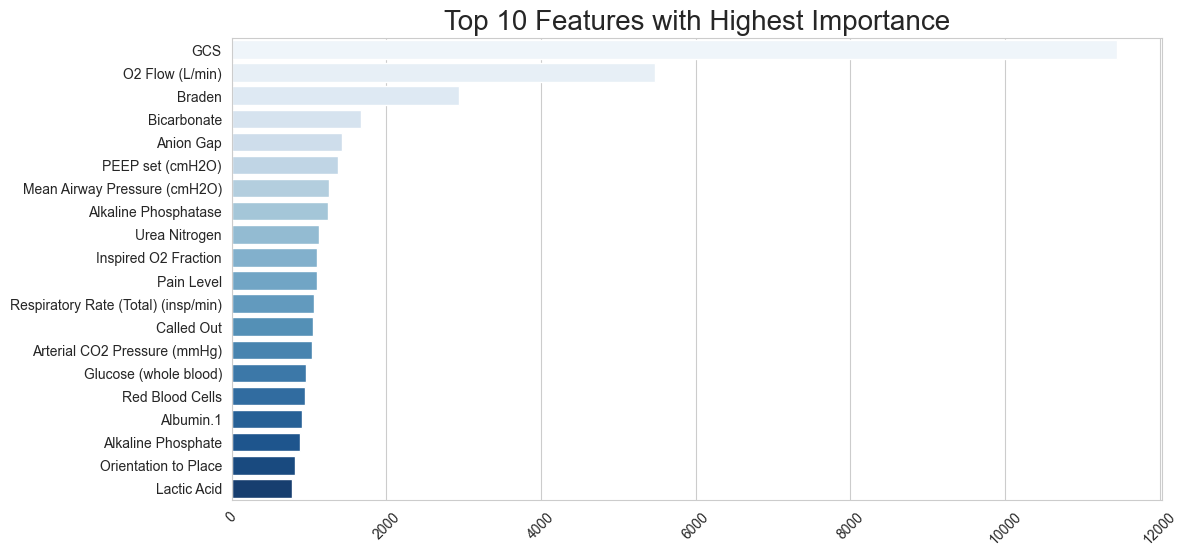

In [8]:
# Set seaborn style and remove gridlines
sns.set_style("whitegrid")

# Top 10 most important features
top_10_features = most_important_df.head(20)

# Plotting
plt.figure(figsize=(12, 6))  # Reduce figure size
plot = sns.barplot(x='Importance', y='Feature', data=top_10_features, hue='Feature', palette="Blues", legend=False)

# Reduce font size slightly 
plt.xlabel('Importance', fontsize=18)
plt.ylabel('Feature', fontsize=18)
plt.title('Top 10 Features with Highest Importance', fontsize=20)

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

plt.ylabel('')
plt.xlabel('')

# Save the plot in high resolution
plt.savefig('plots/mortality_top_20_most_important_features.jpeg', dpi=300)
plt.show()

# ROC | Precision - Recall

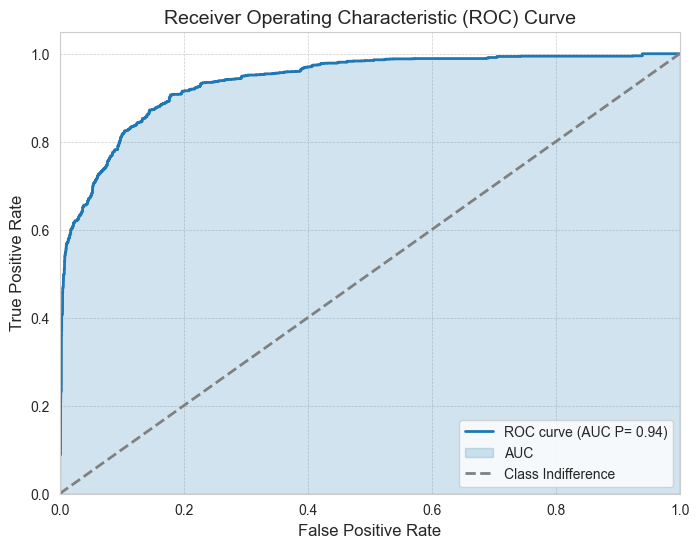

In [9]:
# Get predicted probabilities for the positive class
y_probs = model.predict_proba(X_test)[:, 1]

# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calculate the area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# Set common font family (optional)
plt.rcParams['font.family'] = 'sans-serif' 

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='tab:blue', lw=2, label='ROC curve (AUC P= %0.2f)' % roc_auc)
plt.fill_between(fpr, tpr, color='tab:blue', alpha=0.2, label='AUC')  # Shade the area
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Class Indifference')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)  # Adjust font size as needed
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

Precision:  [0.19804135 0.19813567 0.19835161 ... 1.         1.         1.        ]
Recall:  [1.         1.         1.         ... 0.00618132 0.00343407 0.        ]
Thresholds:  [0.00183356 0.00193642 0.00196539 ... 0.985378   0.9856601  0.9874522 ]


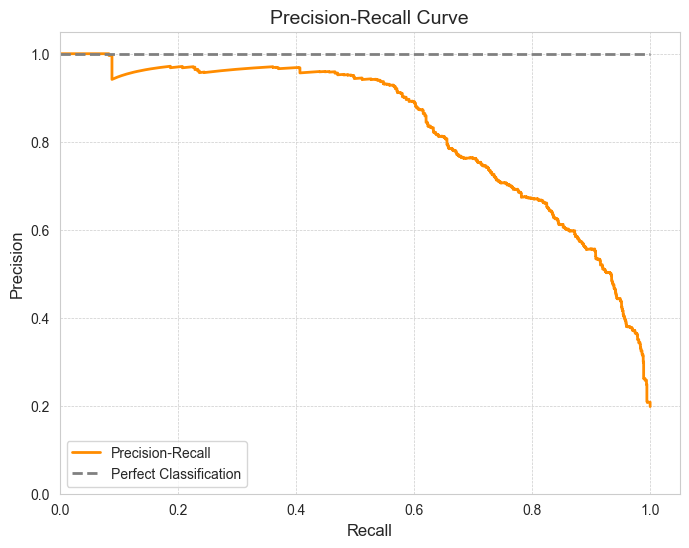

In [10]:
# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Plot formatting
plt.figure(figsize=(8, 6))
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.title('Precision-Recall Curve', fontsize=14)

# Precision-recall curve
plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall')

# Perfect classification line
plt.plot([0, 1], [1, 1], color='gray', lw=2, linestyle='--', label='Perfect Classification')

# Legend location
plt.legend(loc='lower left')  
print("Precision: ", precision)
print("Recall: ", recall)
print("Thresholds: ", thresholds)

# x and y limits
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.show()

# Prepare Prediction File

In [11]:
# Extract subject_id, hadm_id, and Time_Zone from the test data
df_classifier = test_df[['subject_id', 'hadm_id', 'Time_Zone', 'hospital_expire_flag']].copy()

# Add predictions column
df_classifier['prediction(hospital_expire_flag)'] = predictions

In [12]:
# Create the ID column by concatenating the values of 'subject_id', 'hadm_id'
df_classifier['subject_&_hadm'] = df_classifier['subject_id'].astype(str) + df_classifier['hadm_id'].astype(str)

# Create column propability of alive (1 for alive 0 for death)
df_classifier['Prediction_of_alive'] = df_classifier['prediction(hospital_expire_flag)'].apply(lambda x: 1 if x == 0 else 0)

# Create column propability of death 1 for death 0 for alive
df_classifier['Prediction_of_death'] = df_classifier['prediction(hospital_expire_flag)'].apply(lambda x: 1 if x == 1 else 0)

# Replace 0 with 1 and 1 with 0 in the 'hospital_expire_flag' column and rename the column
df_classifier['hospital_expire_flag'] = df_classifier['hospital_expire_flag'].replace({0: 1, 1: 0})
df_classifier = df_classifier.rename(columns={'hospital_expire_flag': 'Ground_Truth_Alive'})

# Remove the 'prediction(hospital_expire_flag)' column
df_classifier = df_classifier.drop(columns=['prediction(hospital_expire_flag)'])

In [13]:
"""
Calculate the probability of Alive and Death
"""

# Create a new column 'denominator' that counts for each 'subject_&_hadm'
df_classifier['Denominator'] = df_classifier.groupby('subject_&_hadm').cumcount() + 1

# Create the 'Numerator' column
df_classifier['Numerator'] = df_classifier.groupby('subject_&_hadm')['Prediction_of_alive'].transform(
    lambda x: x.cumsum()
)

# Fill NaN values with 0
df_classifier['Numerator'] = df_classifier['Numerator'].fillna(0)

# Probability of Alive
df_classifier['Probability_of_Alive'] = df_classifier['Numerator'] / df_classifier['Denominator']

# Probability of Death
df_classifier['Probability_of_Death'] = 1 - df_classifier['Probability_of_Alive']

# Repositioning the columns in the DataFrame
columns_to_move = ['subject_&_hadm', 'subject_id', 'hadm_id', 'Time_Zone',
                   'Prediction_of_alive', 'Prediction_of_death',
                   'Ground_Truth_Alive', 'Numerator','Denominator',
                   'Probability_of_Alive', 'Probability_of_Death']
df_classifier = df_classifier[columns_to_move + [col for col in df_classifier.columns if col not in columns_to_move]]


# Export to csv
#df_classifier.to_csv(export_file_path, index=False)

In [14]:
display (df_classifier)

,subject_&_hadm,subject_id,hadm_id,Time_Zone,Prediction_of_alive,Prediction_of_death,Ground_Truth_Alive,Numerator,Denominator,Probability_of_Alive,Probability_of_Death
0,1698271022391028,16982710,22391028,1,1,0,1,1,1,1.0,0.0
1,1698271022391028,16982710,22391028,2,1,0,1,2,2,1.0,0.0
2,1698271022391028,16982710,22391028,3,1,0,1,3,3,1.0,0.0
3,1698271022391028,16982710,22391028,4,1,0,1,4,4,1.0,0.0
4,1698271022391028,16982710,22391028,5,1,0,1,5,5,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
14699,1999998723865745,19999987,23865745,12,1,0,1,12,12,1.0,0.0
14700,1999998723865745,19999987,23865745,13,1,0,1,13,13,1.0,0.0
14701,1999998723865745,19999987,23865745,14,1,0,1,14,14,1.0,0.0
14702,1999998723865745,19999987,23865745,15,1,0,1,15,15,1.0,0.0


# Assing Ground Truth and Propabilities to Variables 

In [15]:
# Variables
algorithm_label = 'Mimic IV - XGBoost'
xlabel = 'False Positive Rate'
ylabel = 'True Positive Rate'

"""
Assign to variables the values of the first
3, 6, 12 and 24 hour
No1 = first 3 hours
No2 = first 6 hours
...
No16 = first 48 hours
"""
hour1 = df_classifier.loc[df_classifier['Denominator'] == 1] # first 3 hours
hour2 = df_classifier.loc[df_classifier['Denominator'] == 2] # first 6 hours
hour3 = df_classifier.loc[df_classifier['Denominator'] == 4] # first 12 hours
hour4 = df_classifier.loc[df_classifier['Denominator'] == 8] #first 24 hours

"""
Assign to variables values for every hour from
the column Ground Truth Alive and convert from
dataframe to list.
"""

ground_truth_alive1 = hour1["Ground_Truth_Alive"].tolist()
ground_truth_alive2 = hour2["Ground_Truth_Alive"].tolist()
ground_truth_alive3 = hour3["Ground_Truth_Alive"].tolist()
ground_truth_alive4 = hour4["Ground_Truth_Alive"].tolist()

"""
Assign to variables values for every hour from
the column Prob - Alive and convert from
dataframe to list.
"""

prob_alive1 = hour1["Probability_of_Alive"].tolist()
prob_alive2 = hour2["Probability_of_Alive"].tolist()
prob_alive3 = hour3["Probability_of_Alive"].tolist()
prob_alive4 = hour4["Probability_of_Alive"].tolist()

"""
Assign to variables values for every hour from
the column Prob - Dead and convert from
dataframe to list.
"""

prob_dead1 = hour1["Probability_of_Death"].tolist()
prob_dead2 = hour2["Probability_of_Death"].tolist()
prob_dead3 = hour3["Probability_of_Death"].tolist()
prob_dead4 = hour4["Probability_of_Death"].tolist()

"""
To create the Ground Truth Dead per day, I subtract from
the ground_truth_alive of each hour the 1. After the subtraction
I use the abs in order to get the absolute value of it.
So I have the prices without a hitch.
With this process the values of Ground Truth Alive and Ground
Truth Dead are reversed
"""
# Ground Truth Dead per hour
# 1st hour (first 3hours)
ground_truth_dead1=abs(np.subtract(ground_truth_alive1, 1))

# 2nd hour (first 6hours)
ground_truth_dead2=abs(np.subtract(ground_truth_alive2, 1))

# 3rd hour (first 12hours)
ground_truth_dead3=abs(np.subtract(ground_truth_alive3, 1))

# 4th hour (first 24hours)
ground_truth_dead4=abs(np.subtract(ground_truth_alive4, 1))

# ROC Survive

AUC =  0.801687118851298
Thresholds          [2. 1. 0.]
False Possitive Rate [0.         0.36813187 1.        ]
True Possitive Rate [0.         0.97150611 1.        ]


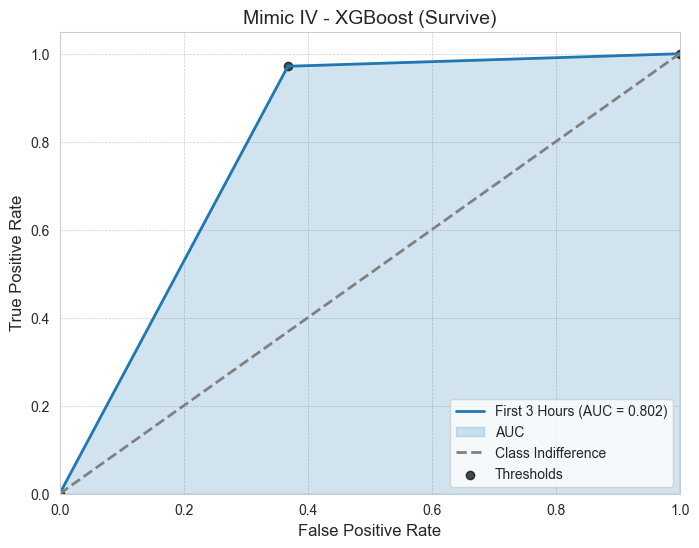

In [16]:
"""First 3 hours"""

auc_1 = roc_auc_score(ground_truth_alive1, prob_alive1)
fpr1, tpr1, thresholds1 = roc_curve(ground_truth_alive1, prob_alive1)

# Plot ROC curve with shaded area (AUC) and class indifference line
plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, color='tab:blue', lw=2, label=f'First 3 Hours (AUC = {auc_1:.3f})')
plt.fill_between(fpr1, tpr1, color='tab:blue', alpha=0.2, label='AUC')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Class Indifference')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Scatter plot for thresholds with customization
plt.scatter(fpr1, tpr1, marker='o', color='black', alpha=0.7, label='Thresholds')  # Adjust transparency

# Threshold Number in the plot
#for i, threshold in enumerate(thresholds1):
#    plt.annotate(f"{threshold:.2f}", (fpr1[i], tpr1[i]), xytext=(5, -5), textcoords='offset points', fontsize=8)  # Annotate thresholds

# Formatting
plt.xlabel(xlabel, fontsize=12)
plt.ylabel(ylabel, fontsize=12)
plt.title(algorithm_label + " (Survive)", fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc='lower right')  # Legend location

# Print statements
print("AUC = ", auc_1)
print("Thresholds         ", thresholds1)
print("False Possitive Rate", fpr1)
print("True Possitive Rate", tpr1)

plt.show()

AUC =  0.8023096306678397
Thresholds          [2.  1.  0.5 0. ]
False Possitive Rate [0.         0.36813187 0.38461538 1.        ]
True Possitive Rate [0.         0.97150611 0.97421981 1.        ]


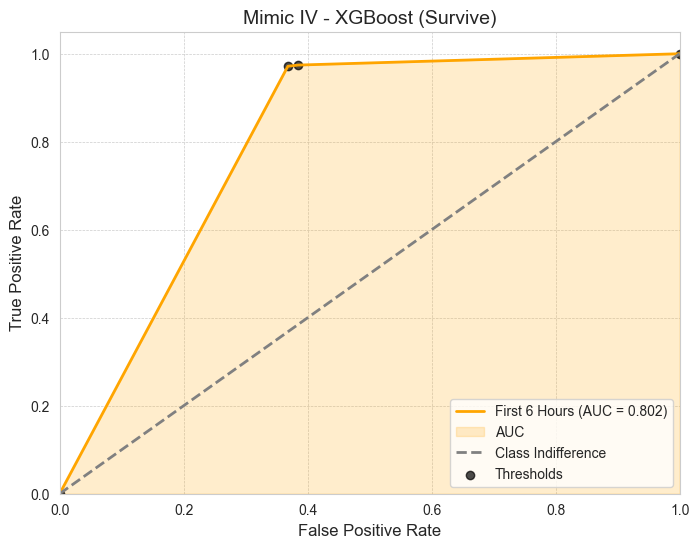

In [17]:
"""First 6 hours"""

# Your existing code for ROC curve (modified for clarity)
auc_2 = roc_auc_score(ground_truth_alive2, prob_alive2)
fpr2, tpr2, thresholds2 = roc_curve(ground_truth_alive2, prob_alive2)

# Combine ROC curve and scatter plot
plt.figure(figsize=(8, 6))
plt.plot(fpr2, tpr2, color='orange', lw=2, label=f'First 6 Hours (AUC = {auc_2:.3f})')
plt.fill_between(fpr2, tpr2, color='orange', alpha=0.2, label='AUC')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Class Indifference')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Scatter plot with transparency and annotations
plt.scatter(fpr2, tpr2, marker='o', color='black', alpha=0.7, label='Thresholds')
# Threshold Number in the plot
#for i, threshold in enumerate(thresholds2):
#    plt.annotate(f"{threshold:.2f}", (fpr2[i], tpr2[i]), xytext=(5, -5), textcoords='offset points', fontsize=8)

# Common formatting
plt.xlabel(xlabel, fontsize=12)
plt.ylabel(ylabel, fontsize=12)
plt.title(algorithm_label + " (Survive)", fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc='lower right')  # Adjust legend location for balance

# Print statements
print("AUC = ", auc_2)
print("Thresholds         ", thresholds2)
print("False Possitive Rate", fpr2)
print("True Possitive Rate", tpr2)

plt.show()

AUC =  0.8055563839145929
Thresholds          [2.   1.   0.5  0.25 0.  ]
False Possitive Rate [0.         0.36263736 0.38461538 0.4010989  1.        ]
True Possitive Rate [0.         0.9687924  0.97693351 0.97829037 1.        ]


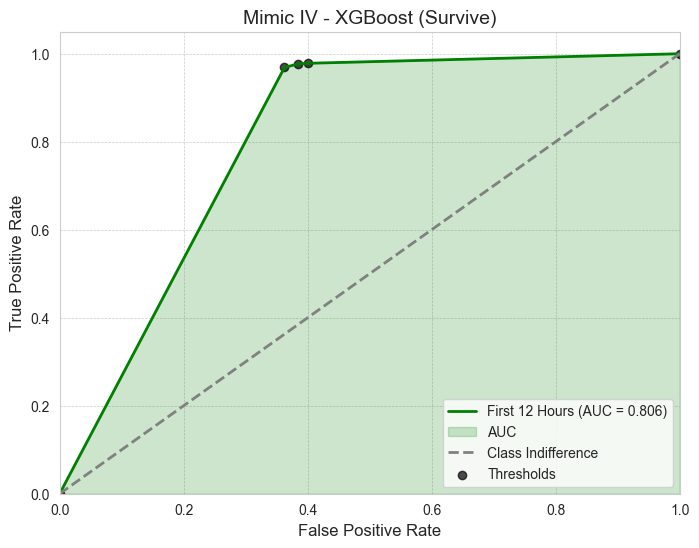

In [18]:
"""First 12 hours"""

# Your existing code for ROC curve (modified for clarity)
auc_3 = roc_auc_score(ground_truth_alive3, prob_alive3)
fpr3, tpr3, thresholds3 = roc_curve(ground_truth_alive3, prob_alive3)

# Combine ROC curve and scatter plot
plt.figure(figsize=(8, 6))
plt.plot(fpr3, tpr3, color='green', lw=2, label=f'First 12 Hours (AUC = {auc_3:.3f})')
plt.fill_between(fpr3, tpr3, color='green', alpha=0.2, label='AUC')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Class Indifference')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Scatter plot with transparency and annotations
plt.scatter(fpr3, tpr3, marker='o', color='black', alpha=0.7, label='Thresholds')

# Threshold Number in the plot
#for i, threshold in enumerate(thresholds3):
#    plt.annotate(f"{threshold:.2f}", (fpr3[i], tpr3[i]), xytext=(5, -5), textcoords='offset points', fontsize=8)

# Common formatting
plt.xlabel(xlabel, fontsize=12)
plt.ylabel(ylabel, fontsize=12)
plt.title(algorithm_label + " (Survive)", fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc='lower right')  # Adjust legend location for balance

# Print statements
print("AUC = ", auc_3)
print("Thresholds         ", thresholds3)
print("False Possitive Rate", fpr3)
print("True Possitive Rate", tpr3)

plt.show()

AUC =  0.8086465773032938
Thresholds          [2.    1.    0.875 0.75  0.625 0.5   0.375 0.25  0.125 0.   ]
False Possitive Rate [0.         0.35714286 0.36813187 0.36813187 0.37912088 0.38461538
 0.3956044  0.4010989  0.41208791 1.        ]
True Possitive Rate [0.         0.96472185 0.97014925 0.97286296 0.97693351 0.97693351
 0.97964722 0.98236092 0.98236092 1.        ]


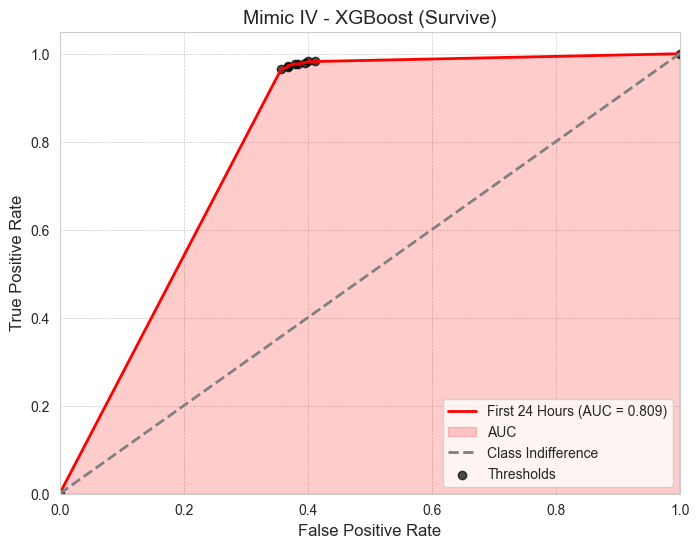

In [19]:
"""First 24 hours"""

# Your existing code for ROC curve (modified for clarity)
auc_4 = roc_auc_score(ground_truth_alive4, prob_alive4)
fpr4, tpr4, thresholds4 = roc_curve(ground_truth_alive4, prob_alive4)

# Combine ROC curve and scatter plot
plt.figure(figsize=(8, 6))
plt.plot(fpr4, tpr4, color='red', lw=2, label=f'First 24 Hours (AUC = {auc_4:.3f})')
plt.fill_between(fpr4, tpr4, color='red', alpha=0.2, label='AUC')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Class Indifference')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Scatter plot with transparency and annotations
plt.scatter(fpr4, tpr4, marker='o', color='black', alpha=0.7, label='Thresholds')

# Threshold Number in the plot
#for i, threshold in enumerate(thresholds4):
#    plt.annotate(f"{threshold:.2f}", (fpr4[i], tpr4[i]), xytext=(5, -5), textcoords='offset points', fontsize=8)

# Common formatting
plt.xlabel(xlabel, fontsize=12)
plt.ylabel(ylabel, fontsize=12)
plt.title(algorithm_label + " (Survive)", fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc='lower right')  # Adjust legend location for balance

# Print statements
print("AUC = ", auc_4)
print("Thresholds         ", thresholds4)
print("False Possitive Rate", fpr4)
print("True Possitive Rate", tpr4)

plt.show()

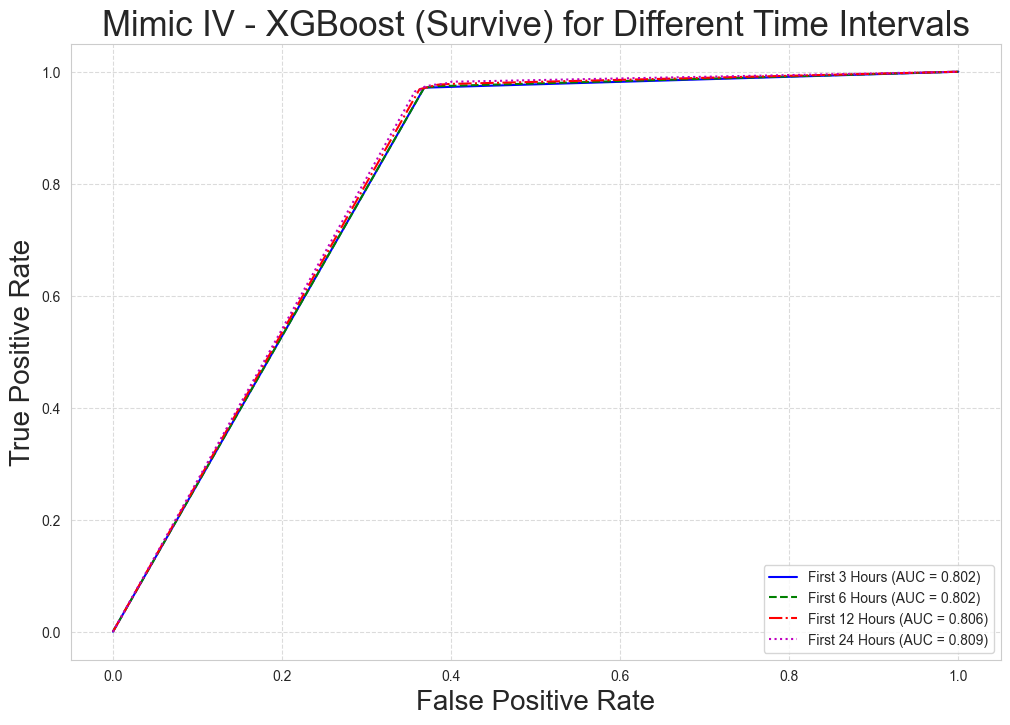

In [20]:
# Calculate AUC scores
auc_3_hours = roc_auc_score(ground_truth_alive1, prob_alive1)
auc_6_hours = roc_auc_score(ground_truth_alive2, prob_alive2)
auc_12_hours = roc_auc_score(ground_truth_alive3, prob_alive3)
auc_24_hours = roc_auc_score(ground_truth_alive4, prob_alive4)

# Create a plot
plt.figure(figsize=(12, 8))

# Plot ROC curves with different line styles and colors
plt.plot(fpr1, tpr1, linestyle='-', color='b', label=f'First 3 Hours (AUC = {auc_3_hours:.3f})')
plt.plot(fpr2, tpr2, linestyle='--', color='g', label=f'First 6 Hours (AUC = {auc_6_hours:.3f})')
plt.plot(fpr3, tpr3, linestyle='-.', color='r', label=f'First 12 Hours (AUC = {auc_12_hours:.3f})')
plt.plot(fpr4, tpr4, linestyle=':', color='m', label=f'First 24 Hours (AUC = {auc_24_hours:.3f})')

# Customize the plot
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.legend(fontsize=12, loc='best')
plt.grid(linestyle='--', alpha=0.7)
plt.title(algorithm_label + " (Survive) for Different Time Intervals", fontsize=25)

plt.legend(loc='lower right')  # Adjust legend location for balance

# Show the plot
plt.show()

# ROC Non Survive

AUC =  0.801687118851298
Thresholds          [2. 1. 0.]
False Possitive Rate [0.         0.02849389 1.        ]
True Possitive Rate [0.         0.63186813 1.        ]


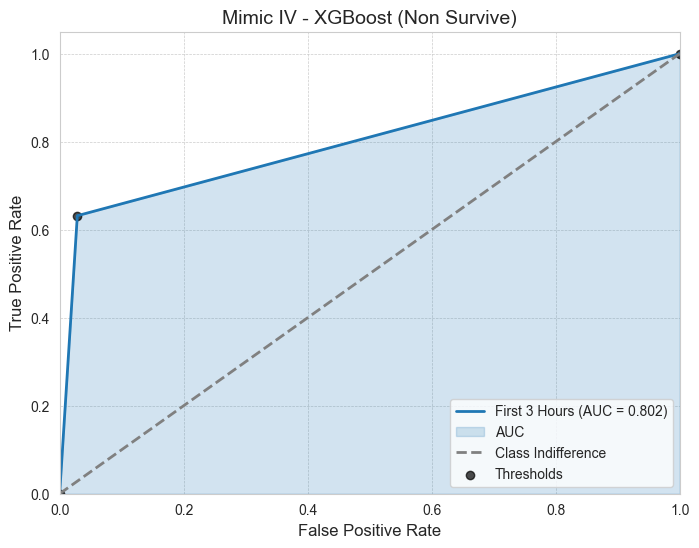

In [21]:
"""First 3 hours"""

auc_1 = roc_auc_score(ground_truth_dead1, prob_dead1)
fpr1, tpr1, thresholds1 = roc_curve(ground_truth_dead1, prob_dead1)

# Plot ROC curve with shaded area (AUC) and class indifference line
plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, color='tab:blue', lw=2, label=f'First 3 Hours (AUC = {auc_1:.3f})')
plt.fill_between(fpr1, tpr1, color='tab:blue', alpha=0.2, label='AUC')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Class Indifference')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Scatter plot for thresholds with customization
plt.scatter(fpr1, tpr1, marker='o', color='black', alpha=0.7, label='Thresholds')  # Adjust transparency

# Threshold Number in the plot
#for i, threshold in enumerate(thresholds1):
#    plt.annotate(f"{threshold:.2f}", (fpr1[i], tpr1[i]), xytext=(5, -5), textcoords='offset points', fontsize=8)  # Annotate thresholds

# Formatting
plt.xlabel(xlabel, fontsize=12)
plt.ylabel(ylabel, fontsize=12)
plt.title(algorithm_label + " (Non Survive)", fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc='lower right')  # Legend location

# Print statements
print("AUC = ", auc_1)
print("Thresholds         ", thresholds1)
print("False Possitive Rate", fpr1)
print("True Possitive Rate", tpr1)

plt.show()

AUC =  0.8023096306678396
Thresholds          [2.  1.  0.5 0. ]
False Possitive Rate [0.         0.02578019 0.02849389 1.        ]
True Possitive Rate [0.         0.61538462 0.63186813 1.        ]


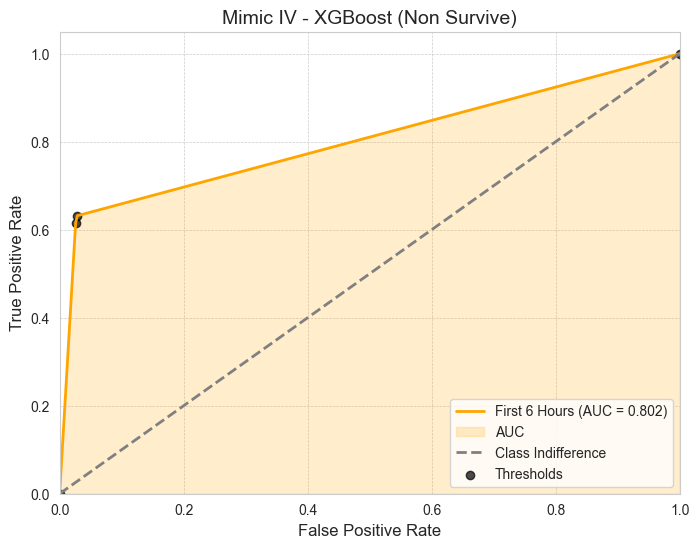

In [22]:
"""First 6 hours"""

# Your existing code for ROC curve (modified for clarity)
auc_2 = roc_auc_score(ground_truth_dead2, prob_dead2)
fpr2, tpr2, thresholds2 = roc_curve(ground_truth_dead2, prob_dead2)

# Combine ROC curve and scatter plot
plt.figure(figsize=(8, 6))
plt.plot(fpr2, tpr2, color='orange', lw=2, label=f'First 6 Hours (AUC = {auc_2:.3f})')
plt.fill_between(fpr2, tpr2, color='orange', alpha=0.2, label='AUC')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Class Indifference')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Scatter plot with transparency and annotations
plt.scatter(fpr2, tpr2, marker='o', color='black', alpha=0.7, label='Thresholds')

# Threshold Number in the plot
#for i, threshold in enumerate(thresholds2):
#    plt.annotate(f"{threshold:.2f}", (fpr2[i], tpr2[i]), xytext=(5, -5), textcoords='offset points', fontsize=8)

# Common formatting
plt.xlabel(xlabel, fontsize=12)
plt.ylabel(ylabel, fontsize=12)
plt.title(algorithm_label + " (Non Survive)", fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc='lower right')  # Adjust legend location for balance

# Print statements
print("AUC = ", auc_2)
print("Thresholds         ", thresholds2)
print("False Possitive Rate", fpr2)
print("True Possitive Rate", tpr2)

plt.show()

AUC =  0.8055563839145928
Thresholds          [2.   1.   0.75 0.25 0.  ]
False Possitive Rate [0.         0.02170963 0.02306649 0.0312076  1.        ]
True Possitive Rate [0.         0.5989011  0.61538462 0.63736264 1.        ]


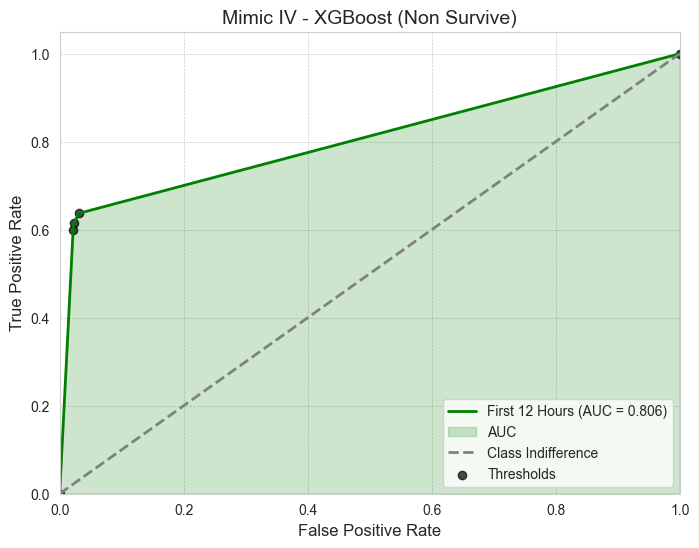

In [23]:
"""First 12 hours"""

# Your existing code for ROC curve (modified for clarity)
auc_3 = roc_auc_score(ground_truth_dead3, prob_dead3)
fpr3, tpr3, thresholds3 = roc_curve(ground_truth_dead3, prob_dead3)

# Combine ROC curve and scatter plot
plt.figure(figsize=(8, 6))
plt.plot(fpr3, tpr3, color='green', lw=2, label=f'First 12 Hours (AUC = {auc_3:.3f})')
plt.fill_between(fpr3, tpr3, color='green', alpha=0.2, label='AUC')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Class Indifference')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Scatter plot with transparency and annotations
plt.scatter(fpr3, tpr3, marker='o', color='black', alpha=0.7, label='Thresholds')

# Threshold Number in the plot
#for i, threshold in enumerate(thresholds3):
#    plt.annotate(f"{threshold:.2f}", (fpr3[i], tpr3[i]), xytext=(5, -5), textcoords='offset points', fontsize=8)

# Common formatting
plt.xlabel(xlabel, fontsize=12)
plt.ylabel(ylabel, fontsize=12)
plt.title(algorithm_label + " (Non Survive)", fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc='lower right')  # Adjust legend location for balance

# Print statements
print("AUC = ", auc_3)
print("Thresholds         ", thresholds3)
print("False Possitive Rate", fpr3)
print("True Possitive Rate", tpr3)

plt.show()

AUC =  0.8086465773032938
Thresholds          [2.    1.    0.875 0.75  0.625 0.5   0.375 0.25  0.125 0.   ]
False Possitive Rate [0.         0.01763908 0.01763908 0.02035278 0.02306649 0.02306649
 0.02713704 0.02985075 0.03527815 1.        ]
True Possitive Rate [0.         0.58791209 0.5989011  0.6043956  0.61538462 0.62087912
 0.63186813 0.63186813 0.64285714 1.        ]


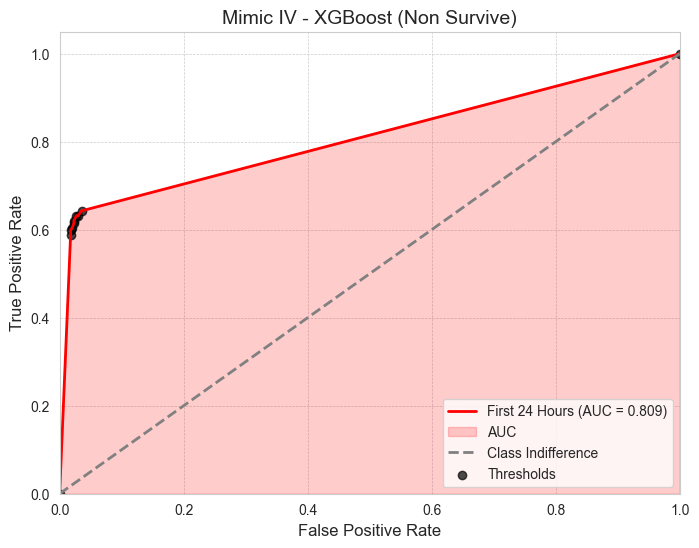

In [24]:
"""First 24 hours"""

# Your existing code for ROC curve (modified for clarity)
auc_4 = roc_auc_score(ground_truth_dead4, prob_dead4)
fpr4, tpr4, thresholds4 = roc_curve(ground_truth_dead4, prob_dead4)

# Combine ROC curve and scatter plot
plt.figure(figsize=(8, 6))
plt.plot(fpr4, tpr4, color='red', lw=2, label=f'First 24 Hours (AUC = {auc_4:.3f})')
plt.fill_between(fpr4, tpr4, color='red', alpha=0.2, label='AUC')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Class Indifference')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Scatter plot with transparency and annotations
plt.scatter(fpr4, tpr4, marker='o', color='black', alpha=0.7, label='Thresholds')

# Threshold Number in the plot
#for i, threshold in enumerate(thresholds4):
#    plt.annotate(f"{threshold:.2f}", (fpr4[i], tpr4[i]), xytext=(5, -5), textcoords='offset points', fontsize=8)

# Common formatting
plt.xlabel(xlabel, fontsize=12)
plt.ylabel(ylabel, fontsize=12)
plt.title(algorithm_label + " (Non Survive)", fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc='lower right')  # Adjust legend location for balance

# Print statements
print("AUC = ", auc_4)
print("Thresholds         ", thresholds4)
print("False Possitive Rate", fpr4)
print("True Possitive Rate", tpr4)

plt.show()

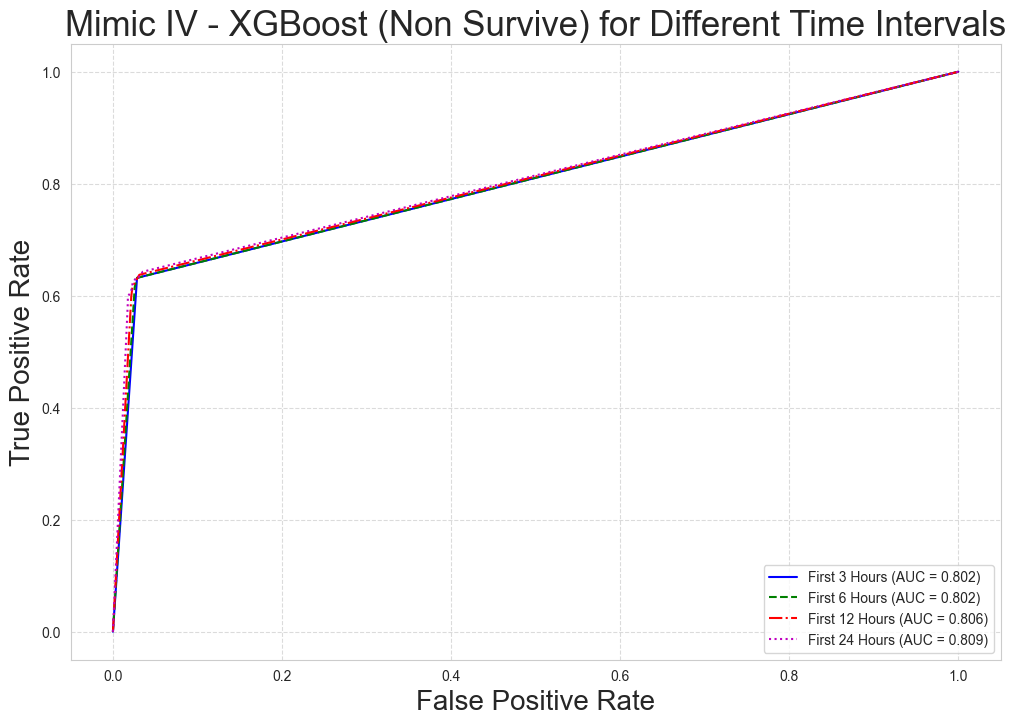

In [25]:
# Calculate AUC scores
auc_3_hours = roc_auc_score(ground_truth_dead1, prob_dead1)
auc_6_hours = roc_auc_score(ground_truth_dead2, prob_dead2)
auc_12_hours = roc_auc_score(ground_truth_dead3, prob_dead3)
auc_24_hours = roc_auc_score(ground_truth_dead4, prob_dead4)

# Create a plot
plt.figure(figsize=(12, 8))

# Plot ROC curves with different line styles and colors
plt.plot(fpr1, tpr1, linestyle='-', color='b', label=f'First 3 Hours (AUC = {auc_3_hours:.3f})')
plt.plot(fpr2, tpr2, linestyle='--', color='g', label=f'First 6 Hours (AUC = {auc_6_hours:.3f})')
plt.plot(fpr3, tpr3, linestyle='-.', color='r', label=f'First 12 Hours (AUC = {auc_12_hours:.3f})')
plt.plot(fpr4, tpr4, linestyle=':', color='m', label=f'First 24 Hours (AUC = {auc_24_hours:.3f})')

# Customize the plot
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.legend(fontsize=12, loc='best')
plt.grid(linestyle='--', alpha=0.7)
plt.title(algorithm_label + " (Non Survive) for Different Time Intervals", fontsize=25)

plt.legend(loc='lower right')  # Adjust legend location for balance

# Show the plot
plt.show()